In [2]:
import os
from tempfile import tempdir
from termios import TOSTOP
from time import time
from turtle import color
from unittest.mock import NonCallableMagicMock
import pandas as pd
import numpy as np
import warnings
import math
import re

import seaborn as sns
warnings.filterwarnings("ignore")

import sys
sys.path.append("./")

from pathlib import Path

import tqdm
import importlib

import matplotlib.pyplot as plt
# from PySide2.QtWidgets import QFileDialog, QApplication
# from PySide2.QtCore import Qt
from copy import copy 

from corems.mass_spectra.input import rawFileReader
from corems.molecular_id.factory.classification import HeteroatomsClassification, Labels
from corems.molecular_id.search.priorityAssignment import OxygenPriorityAssignment
from corems.molecular_id.search.molecularFormulaSearch import SearchMolecularFormulas
from corems.encapsulation.factory.parameters import MSParameters
from corems.encapsulation.constant import Atoms
from corems.mass_spectrum.calc.Calibration import MzDomainCalibration

import importlib

import corems.lc_icpms_ftms.calc.lc_icrms_qc_assign as icrms

importlib.reload(icrms)



def getParser(file):
    parser = rawFileReader.ImportMassSpectraThermoMSFileReader(file)
    return parser

def assign_formula(parser, interval, timerange, refmasslist=None):
    #Function to build formula assignment lists
    #Retrieve TIC for MS1 scans over the time range between 'timestart' and 'timestop' 

    tic=parser.get_tic(ms_type='MS')[0]
    tic_df=pd.DataFrame({'time': tic.time,'scan': tic.scans})

    times=list(range(timerange[0],timerange[1],interval))

    results=[]
    
    for timestart in times:

        scans=tic_df[tic_df.time.between(timestart,timestart+interval)].scan.tolist()

        mass_spectrum = parser.get_average_mass_spectrum_by_scanlist(scans)    
        mass_spectrum.molecular_search_settings.ion_charge = 1

        #mass_spectrum.mass_spectrum.settings.calib_sn_threshold
        #mass_spectrum.mass_spectrum.settings.calib_pol_order
        #mass_spectrum.recalibrate_mass_spectrum(mass_spectrum, imzmeas, mzrefs, order=2)
        #MzDomainCalibration(mass_spectrum, ref_file_location).run()

        if refmasslist:
            mass_spectrum.settings.min_calib_ppm_error = 10
            mass_spectrum.settings.max_calib_ppm_error = -10
            calfn = MzDomainCalibration(mass_spectrum, refmasslist)
            ref_mass_list_fmt = calfn.load_ref_mass_list(refmasslist)

            imzmeas, mzrefs = calfn.find_calibration_points(mass_spectrum, ref_mass_list_fmt,
                                                        calib_ppm_error_threshold=(0, 2.0),
                                                        calib_snr_threshold=3)

            calfn.recalibrate_mass_spectrum(mass_spectrum, imzmeas, mzrefs, order=2)


        SearchMolecularFormulas(mass_spectrum, first_hit=False).run_worker_mass_spectrum()

        mass_spectrum.percentile_assigned(report_error=True)

        assignments=mass_spectrum.to_dataframe()

        assignments['Time']=timestart

        results.append(assignments)
    
    results=pd.concat(results,ignore_index=True)

    return(results)    

def plot_ms(df1, start_mz, end_mz, tstart, df2=None,df3=None, assignment= None, ax_ms=None, lbls=None, norm=False, labs=False, colors=None):   
    if ax_ms == None:
        f, ax = plt.subplots()
    
    else:
        ax = ax_ms

    if colors is not None:
        cols = colors
    else:
        cols = ['C0', 'C1', 'C2']
    mzrange= end_mz - start_mz
    ms_t_int=df1[df1['Time'] == tstart]
    ms_df = ms_t_int[((ms_t_int['Calibrated m/z']-start_mz)<mzrange) & ((ms_t_int['Calibrated m/z']-start_mz)>0)]

    maxdf1 = max(ms_df['S/N'])

    if norm:
        ms_df['S/N Norm'] = ms_df['S/N'] / maxdf1
    else:
        ms_df['S/N Norm'] = ms_df['S/N'] 

    

    print(ms_df['S/N Norm'])

    if lbls is not None:
        labels = lbls
    else:
        lbls = [None, None, None]

 
    _, stemlines1, _ =ax.stem('Calibrated m/z','S/N Norm',data=ms_df,  markerfmt=' ', basefmt=' ', linefmt=cols[0], label = labels[0])
    
    if df2 is not None:
        ms_t_int2=df2[df2['Time'] == tstart]
        ms_df2 = ms_t_int2[(abs(ms_t_int2['Calibrated m/z']-start_mz)<mzrange)& ((ms_t_int2['Calibrated m/z']-start_mz)>0)]

        maxdf2 = max(ms_df2['S/N'])

        if norm:
            ms_df2['S/N Norm'] = ms_df2['S/N'] / maxdf2
        else:
            ms_df2['S/N Norm'] = ms_df2['S/N'] 
        
        _, stemlines2, _ =ax.stem('Calibrated m/z','S/N Norm',data=ms_df2,  markerfmt=' ', basefmt=' ', linefmt=cols[1], label = labels[1])

    if df3 is not None:
        ms_t_int3=df3[df3['Time'] == tstart]
        ms_df3 = ms_t_int3[(abs(ms_t_int3['Calibrated m/z']-start_mz)<mzrange)& ((ms_t_int3['Calibrated m/z']-start_mz)>0)]

        maxdf3 = max(ms_df3['S/N'])

        if norm:
            ms_df3['S/N Norm'] = ms_df3['S/N'] / maxdf3
        else:
            ms_df3['S/N Norm'] = ms_df3['S/N'] 
        
        _, stemlines3, _ =ax.stem('Calibrated m/z','S/N Norm',data=ms_df3,  markerfmt=' ', basefmt=' ', linefmt=cols[2], label = labels[2])
    
    if df3 is not None:
        ax.set_ylim(0, max([maxdf1, maxdf2, maxdf3]) * 1.1)
    elif df2 is not None:
        ax.set_ylim(0, max([maxdf1, maxdf2]) * 1.1)
    else: 
        ax.set_ylim(0, maxdf1 * 1.1)

    ax.set_xlim(left = start_mz - mzrange*0.1, right = start_mz + mzrange + mzrange*0.1) 

    if labs:
        for mzr,peakr,mf,er in zip(ms_df['Calibrated m/z'], ms_df['S/N Norm'], ms_df['Molecular Formula'],  ms_df['m/z Error (ppm)']):

            #if (mzr- target_mz)  == 0:
            #    mz_text = ' m/z\n%.4f' % (mzr)
            #else:
            #    mz_text = r'$\Delta$' + ' m/z\n%.4f' % (mzr- target_mz)

            mz_text = 'm/z %.4f\n%s\n%.3f ppm' % (mzr,mf,er)
            ax.text(mzr, peakr + 0.02 *max(ms_df['S/N Norm']), mz_text, ha = 'center', fontsize = 'xx-small', weight = 'bold', color=cols[0])

        if df2 is not None:

            for mzr,peakr,mf, er in zip(ms_df2['Calibrated m/z'], ms_df2['S/N Norm'], ms_df2['Molecular Formula'], ms_df2['m/z Error (ppm)']):

            #if (mzr- target_mz)  == 0:
            #    mz_text = ' m/z\n%.4f' % (mzr)
            #else:
            #    mz_text = r'$\Delta$' + ' m/z\n%.4f' % (mzr- target_mz)

                mz_text = 'm/z %.4f\n%s\n%.3f ppm' % (mzr,mf,er)
                ax.text(mzr, peakr + 0.02 *max(ms_df2['S/N Norm']), mz_text, ha = 'center', fontsize = 'xx-small', weight = 'bold', color = cols[1])

        if df3 is not None:

            for mzr,peakr,mf, er in zip(ms_df3['Calibrated m/z'], ms_df3['S/N Norm'], ms_df3['Molecular Formula'], ms_df3['m/z Error (ppm)']):

            #if (mzr- target_mz)  == 0:
            #    mz_text = ' m/z\n%.4f' % (mzr)
            #else:
            #    mz_text = r'$\Delta$' + ' m/z\n%.4f' % (mzr- target_mz)

                mz_text = 'm/z %.4f\n%s\n%.3f ppm' % (mzr,mf,er)
                ax.text(mzr, peakr + 0.02 *max(ms_df3['S/N Norm']), mz_text, ha = 'center', fontsize = 'xx-small', weight = 'bold', color = cols[2])

   # theor_mz=pattern.mdiff+result['mass']
   # theor_int=pattern.ratio*result['abundance']
   # ax.stem(theor_mz,theor_int, basefmt=' ',linefmt='gray')

   # for isotope in pattern.isotope[pattern.requirement=='Y']:
   #     ax.stem('mz','intense',data=result[isotope],  markerfmt=' ', basefmt=' ',linefmt='red')
    if ax == None:

        ax.legend(('other', 'target'),bbox_to_anchor=(1.05, 1.0), loc='upper left',frameon=False)

        if(assignment):

            mf = assignment[0]
            score = assignment[1]
            er = assignment[2]

            ax.text(1.05,0.7,mf,transform=ax.transAxes)
            ax.text(1.05,0.6,'Error (ppm) = %.3f ' %er ,transform=ax.transAxes)
            ax.text(1.05,0.5,'Score = %.3f' %score ,transform=ax.transAxes)

    if norm: 
        ax.set(xlabel='Calibrated m/z',ylabel='Normalized S/N')
    else: 
        ax.set(xlabel='Calibrated m/z',ylabel='S/N')
    #ax.set_title('%.2f' %timerange[0] + ' to %.2f' %timerange[1] +' min', fontsize = 'medium')
    ax.legend(bbox_to_anchor = (1.00, 0.5), frameon =False, loc = 'center left')
    ax.axhline(y=0.0, color='black')
    plt.setp(stemlines1,'color', cols[0], 'linewidth', 2)
    if df2 is not None:
        plt.setp(stemlines2, 'color', cols[1],'linewidth', 2)
    if df3 is not None:
        plt.setp(stemlines3, 'color', cols[2],'linewidth', 2)
    plt.tight_layout()
    if ax_ms == None:
        return ax


def filterMzRange(results, mz_range):

    mz_i = mz_range[0]
    mz_f = mz_range[1]

    sub = results[(results['m/z'] >= mz_i) & (results['m/z'] <= mz_f)]

    return sub



In [36]:

def pltMZerror(results, bins=50):
    ## assignment error distribution
    _, ax = plt.subplots()
    for mol_class in sorted(results['mol_class'].unique()):

        counts, bins = np.histogram(np.asarray(results[results['mol_class']==mol_class]['m/z Error (ppm)']),bins = bins)

        ax.plot(bins[:-1], counts, label = mol_class)

    ax.set_xlim(-0.5,0.5)
    ax.legend(frameon=False)
    ax.set_xlabel('m/z assignment error (ppm)')
    ax.set_ylabel('# assigned features')

    return ax

def pltMZerror_pts(results):
    ## assignment error distribution
    _, ax = plt.subplots()
    for mol_class in sorted(results['mol_class'].unique()):

        ax.scatter(results[results['mol_class']==mol_class]['Calibrated m/z'], results[results['mol_class']==mol_class]['m/z Error (ppm)'], label = mol_class)

    ax.set_xlim(200,1200)
    ax.legend(frameon=False,bbox_to_anchor=(1.0, 0.5))
    ax.set_xlabel('calibrated m/z')
    ax.set_ylabel('assignment error (ppm)')

    return ax


In [34]:

def assignMolClass(resultsdf, mz_cutoff = 800, sn_lim = 3):

    filtered_results=resultsdf[(resultsdf['m/z']<mz_cutoff) & (resultsdf['S/N']>sn_lim)]

    filtered_results['N']=filtered_results['N'].fillna(0)
    filtered_results['O']=filtered_results['O'].fillna(0)
    #filtered_results['S']=filtered_results['S'].fillna(0)
    #filtered_results['P']=filtered_results['Fe'].fillna(0)
    #filtered_results['Cu']=filtered_results['Cu'].fillna(0)

    filtered_results['mol_class']='Unassigned'
    filtered_results['mol_class'][filtered_results['C']>0]='CHO'
    filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['N']>0.5)]='CHON'
    #filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['S']>0.5)]='CHOS'
    #filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['Fe']>0.5)]='CHOFe'
    #iltered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['Cu']>0.5)]='CHOCu'
    #filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['Cu']>0.5) & (filtered_results['N']>0.5)]='CHONCu'
    #filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['Cu']>0.5) & (filtered_results['S']>0.5)]='CHOSCu'
    #filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['Na']>0.5) & (filtered_results['N']>0.5)]='CHONNa'
    #filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['P']>0.5) & (filtered_results['Na']>0.5) & (filtered_results['N']>0.5)]='CHONPNa'


    results= filtered_results #[filtered_results['mol_class'] != 'Unassigned'] #[filtered_results['Is Isotopologue']==0]
    results['N/C']=results['O']/results['C']
    results['H/C']=results['H']/results['C']
    results['N/C']=results['N']/results['C']

    return results



In [163]:
def add_mzwindow_col(df):    

    df['m/z window'] = df.index
    
    
    for file, r in zip(df['file'], range(len(df['file']))):

        if ('400_500' in file) or ('400-500' in file):

            df['m/z window'].iloc[r] = '400-500 m/z'

        elif ('500_600' in file) or ('500-600' in file):

            df['m/z window'].iloc[r] = '500-600 m/z'
    
        elif ('600_700' in file) or ('600-700' in file):

            df['m/z window'].iloc[r] = '600-700 m/z'

        elif ('700_800' in file) or ('700-800' in file):

            df['m/z window'].iloc[r] = '700-800 m/z'

        elif ('400_600' in file) or ('400-600' in file):

            df['m/z window'].iloc[r] = '400-600 m/z'
        
        elif ('600_800' in file) or ('600-800' in file):

            df['m/z window'].iloc[r] = '600-800 m/z'
            
        elif 'full' in file:

            df['m/z window'].iloc[r] = '200-1200 m/z'

    return df 

In [82]:
def getUniqueFeatures(df):    
    #Create a list of all unique features and describe their intensity. 
    print('total # results: %s' %len(df))
    #define a list of unique features (time, formula) with 'areas' determined for each sample. There may be a slight bug that causes the unique list to grow...
    uniquelist=[]
    for time in df.Time.unique():
        current=df[df.Time==time]
        current=current.sort_values(by=['m/z Error (ppm)'],ascending=True)
        currentunique=current.drop_duplicates(subset=['Molecular Formula'])
        currentunique=currentunique[currentunique['C']>1]
        currentunique=currentunique.set_index(['Molecular Formula'],drop=False)
        for file in df['file'].unique():
            current_file=current[current['file']==file].drop_duplicates(subset=['Molecular Formula'])
            current_file=current_file.rename(columns={'Peak Height':file})
            current_file=current_file.set_index(['Molecular Formula'],drop=False)
            #current_file[file].fillna(0)
            currentunique=currentunique.join(current_file[file])
        uniquelist.append(currentunique)

    unique_results=pd.concat(uniquelist,ignore_index=True)
    unique_results['N/C']=unique_results['N']/unique_results['C']
    #unique_results['blank']=unique_results[blankfile]/unique_results['Peak Height']
    #unique_results=unique_results[unique_results['blank']<blnk_thresh]


    print('# unique results: %s' %len(unique_results))

    return unique_results


In [121]:
def plotUnique(df,ps=50,includeBlanks=True):
    if includeBlanks != True:
        print("HEREERE")
        print(df['file'].unique())
        mask = df['file'].str.contains('qh2o', case=False, na=False)
        df=df[mask]
    else:
        df=df
    print(df['file'].unique())
    fig, (ax2, ax3, ax4) = plt.subplots(1,3,figsize = (20,6))
    #sns.violinplot(x="Time", y="O/C", hue='mol_class', data=unique_results, ax=ax1)
    sns.scatterplot(x='m/z',y='m/z Error (ppm)', hue='m/z window', data=df, ax=ax2,s=ps)
    #ax1.set(xlabel='Time (min)')
    #ax2.set(xlabel='Time (min)')
    sns.scatterplot(x='m/z',y='m/z Error (ppm)',hue='N', style='m/z window',data=df,ax=ax3,s=ps)
    sns.scatterplot(x='m/z',y='Resolving Power',hue='mol_class',data=df,ax=ax4)
    
    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax4.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    #fig.savefig('unique_results.pdf', bbox_to_inches='tight')

    return df

In [83]:
def blankSubtract(unique_results, blnkfile, blnkthresh = 0.9):

    df = unique_results

    df_bs = []

    for file in df['file'].unique():

        bs_col = 'bs_%s' %file
        df[bs_col] = df[file] / df[blnkfile]

        df_sub = df[df[bs_col] > blnkthresh]

        df_bs.append(df_sub)
    
    complete_df_bs = pd.concat(df_bs, ignore_index=True)

    return complete_df_bs

In [ ]:
dirdir = '/Users/christiandewey/Library/CloudStorage/Box-Box/Boiteau Lab/Mass Spec Data/21T at NHMFL/2022-10 Nicole & Christian/Christian/spring/'
#file_location='/Users/christiandewey/Library/CloudStorage/Box-Box/Boiteau Lab/Mass Spec Data/21T at NHMFL/2022-10 Nicole & Christian/Christian/spring/400-500/'
#file_location='/Users/christiandewey/Library/CloudStorage/Box-Box/Boiteau Lab/Mass Spec Data/21T at NHMFL/2021_August_OC2102A/OC2012A/'
dirlist=os.listdir(dirdir)
os.chdir(dirdir)

print(dirlist)
MSfiles={}

for dir in dirlist:
    
    if os.path.isdir(dir) and (dir != '400-500') and (dir != 'extra'):
        print(dir)
        os.chdir('./' + dir)
        filelist = os.listdir('.')
        for file in filelist:
            if '.raw' in file:
                print(file)
                parser = rawFileReader.ImportMassSpectraThermoMSFileReader(file)
                MSfiles[file]={'parser': parser}
        os.chdir('..')


In [ ]:
data = icrms.lc_icr_assign(dir)

data.master_data_holder = MSfiles

print(data.master_data_holder.keys())
data._raw_filelist = data.master_data_holder.keys()


In [59]:
dirdir = '/Users/christiandewey/Library/CloudStorage/Box-Box/Boiteau Lab/Mass Spec Data/21T at NHMFL/2022-10 Nicole & Christian/Christian/spring/'
#file_location='/Users/christiandewey/Library/CloudStorage/Box-Box/Boiteau Lab/Mass Spec Data/21T at NHMFL/2022-10 Nicole & Christian/Christian/spring/400-500/'
#file_location='/Users/christiandewey/Library/CloudStorage/Box-Box/Boiteau Lab/Mass Spec Data/21T at NHMFL/2021_August_OC2102A/OC2012A/'
dirlist=os.listdir(dirdir)
os.chdir(dirdir)

print(dirlist)
MSfiles2={}

for dir in dirlist:
    
    if os.path.isdir(dir) and (dir == '400-500'):
        print(dir)
        os.chdir('./' + dir)
        filelist = os.listdir('.')
        for file in filelist:
            if '.raw' in file:
                print(file)
                parser = rawFileReader.ImportMassSpectraThermoMSFileReader(file)
                MSfiles2[file]={'parser': parser}
        os.chdir('..')


['assignments', '.DS_Store', '400-500', '500-600', '700-800', '600-800', '400-600', 'extra', 'db', '600-700']
400-500
20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz_221105013731.raw
20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500_221104214121.raw
20221103_LBA_Boiteau_Zorbax3p5_qh2o_fullmz_221105005017.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_400_500.raw
20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500.raw
20221103_LBA_Boiteau_Zorbax3p5_qh2o_fullmz.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_400_500_221105022444.raw


In [86]:
dirdir = '/Users/christiandewey/Library/CloudStorage/Box-Box/Boiteau Lab/Mass Spec Data/21T at NHMFL/2022-10 Nicole & Christian/Christian/spring/'
#file_location='/Users/christiandewey/Library/CloudStorage/Box-Box/Boiteau Lab/Mass Spec Data/21T at NHMFL/2022-10 Nicole & Christian/Christian/spring/400-500/'
#file_location='/Users/christiandewey/Library/CloudStorage/Box-Box/Boiteau Lab/Mass Spec Data/21T at NHMFL/2021_August_OC2102A/OC2012A/'
dirlist=os.listdir(dirdir)
os.chdir(dirdir)

print(dirlist)
MSfiles3={}

for dir in dirlist:
    
    if os.path.isdir(dir) and (dir == 'qh2o'):
        print(dir)
        os.chdir('./' + dir)
        filelist = os.listdir('.')
        for file in filelist:
            if '.raw' in file:
                print(file)
                parser = rawFileReader.ImportMassSpectraThermoMSFileReader(file)
                MSfiles3[file]={'parser': parser}
        os.chdir('..')

['assignments', '.DS_Store', '400-500', '500-600', '700-800', '600-800', '400-600', 'extra', 'db', 'qh2o', '600-700']
qh2o
20221103_LBA_Boiteau_Zorbax3p5_qh2o_700-800_221105000304.raw
20221103_LBA_Boiteau_Zorbax3p5_qh2o_600-700_221104231550.raw
20221103_LBA_Boiteau_Zorbax3p5_qh2o_500-600_221104222837.raw


In [87]:
data3 = icrms.lc_icr_assign(dir)


dict_keys(['20221103_LBA_Boiteau_Zorbax3p5_qh2o_700-800_221105000304.raw', '20221103_LBA_Boiteau_Zorbax3p5_qh2o_600-700_221104231550.raw', '20221103_LBA_Boiteau_Zorbax3p5_qh2o_500-600_221104222837.raw'])


In [178]:

data3.master_data_holder = MSfiles3

print(data3.master_data_holder.keys())
data3._raw_filelist = data3.master_data_holder.keys()

dict_keys(['20221103_LBA_Boiteau_Zorbax3p5_qh2o_700-800_221105000304.raw', '20221103_LBA_Boiteau_Zorbax3p5_qh2o_600-700_221104231550.raw', '20221103_LBA_Boiteau_Zorbax3p5_qh2o_500-600_221104222837.raw'])


In [60]:
data2 = icrms.lc_icr_assign(dir)


dict_keys(['20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz_221105013731.raw', '20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500_221104214121.raw', '20221103_LBA_Boiteau_Zorbax3p5_qh2o_fullmz_221105005017.raw', '20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz.raw', '20221103_LBA_Boiteau_Zorbax3p5_spring_400_500.raw', '20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500.raw', '20221103_LBA_Boiteau_Zorbax3p5_qh2o_fullmz.raw', '20221103_LBA_Boiteau_Zorbax3p5_spring_400_500_221105022444.raw'])


In [179]:

data2.master_data_holder = MSfiles2

print(data2.master_data_holder.keys())
data2._raw_filelist = data2.master_data_holder.keys()

dict_keys(['20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz_221105013731.raw', '20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500_221104214121.raw', '20221103_LBA_Boiteau_Zorbax3p5_qh2o_fullmz_221105005017.raw', '20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz.raw', '20221103_LBA_Boiteau_Zorbax3p5_spring_400_500.raw', '20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500.raw', '20221103_LBA_Boiteau_Zorbax3p5_qh2o_fullmz.raw', '20221103_LBA_Boiteau_Zorbax3p5_spring_400_500_221105022444.raw'])


In [26]:
# 1: assign formula to full scan 
MSParameters.mass_spectrum.threshold_method = 'signal_noise'
MSParameters.mass_spectrum.s2n_threshold = 2
MSParameters.ms_peak.peak_min_prominence_percent = 0.001

MSParameters.molecular_search.error_method = 'None'
MSParameters.molecular_search.min_ppm_error = -0.3
MSParameters.molecular_search.max_ppm_error = 0.3

MSParameters.molecular_search.isProtonated = True
MSParameters.molecular_search.isRadical = False
MSParameters.molecular_search.isAdduct = False

MSParameters.molecular_search.score_method = "prob_score"
MSParameters.molecular_search.output_score_method = "prob_score"


MSParameters.molecular_search.url_database = None
MSParameters.molecular_search.min_dbe = -1
MSParameters.molecular_search.max_dbe = 20

MSParameters.molecular_search.usedAtoms['C'] = (1,50)
MSParameters.molecular_search.usedAtoms['H'] = (4,100)
MSParameters.molecular_search.usedAtoms['O'] = (1,20)
MSParameters.molecular_search.usedAtoms['N'] = (0,4)
#MSParameters.molecular_search.usedAtoms['Cu'] = (0,1)
#MSParameters.molecular_search.usedAtoms['S'] = (0,1)

In [ ]:
timerange = [4,30]  # start (min) to stop (min)
interval = 2  # min 
refmasslist = "/Users/christiandewey/CoreMS/tests/tests_data/ftms/nom_pos.ref"

data.assign_formula(interval = interval, timerange = timerange, refmasslist = refmasslist)


In [ ]:
timerange = [4,30]  # start (min) to stop (min)
interval = 2  # min 
refmasslist = "/Users/christiandewey/CoreMS/tests/tests_data/ftms/nom_pos.ref"

data2.assign_formula(interval = interval, timerange = timerange, refmasslist = refmasslist)

In [ ]:
timerange = [4,30]  # start (min) to stop (min)
interval = 2  # min 
refmasslist = "/Users/christiandewey/CoreMS/tests/tests_data/ftms/nom_pos.ref"

data3.assign_formula(interval = interval, timerange = timerange, refmasslist = refmasslist)

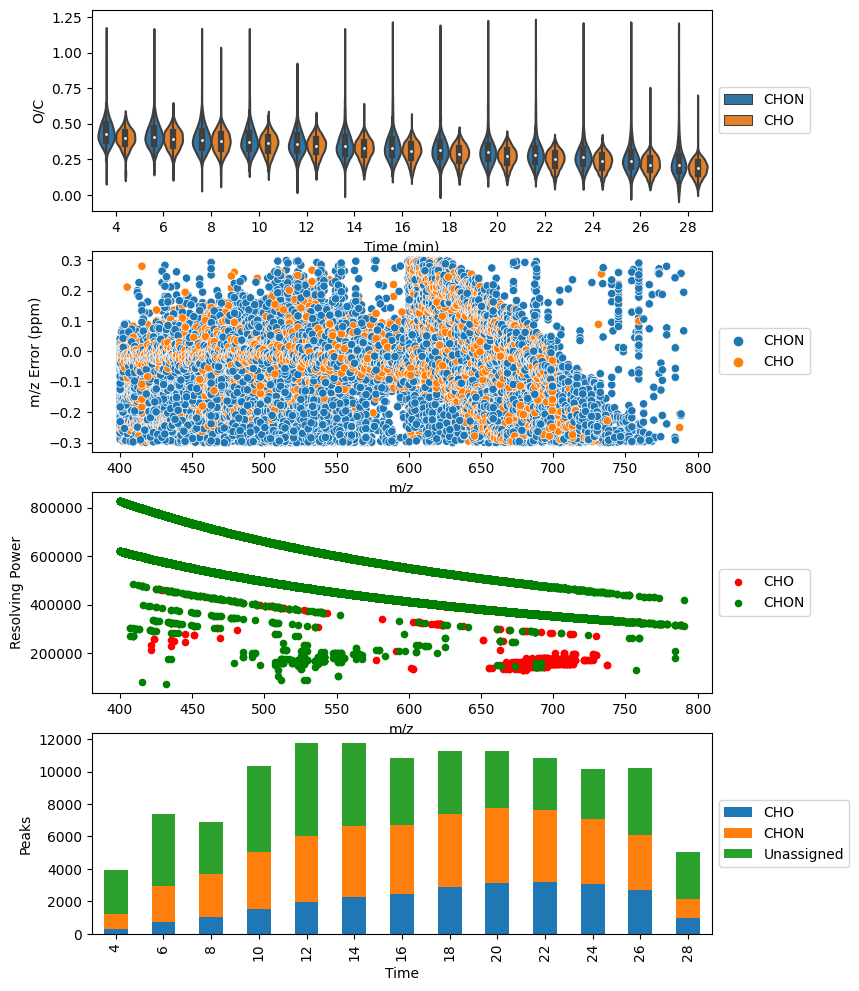

In [30]:
data.assess_all_results()

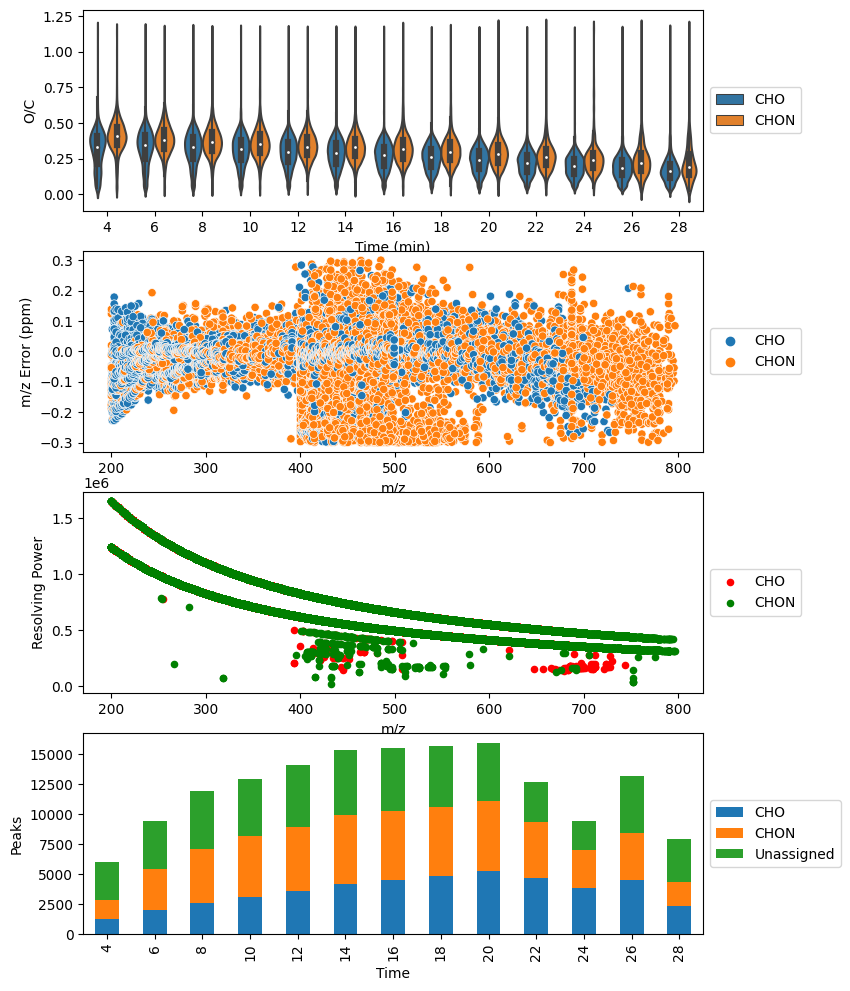

In [63]:
data2.assess_all_results()

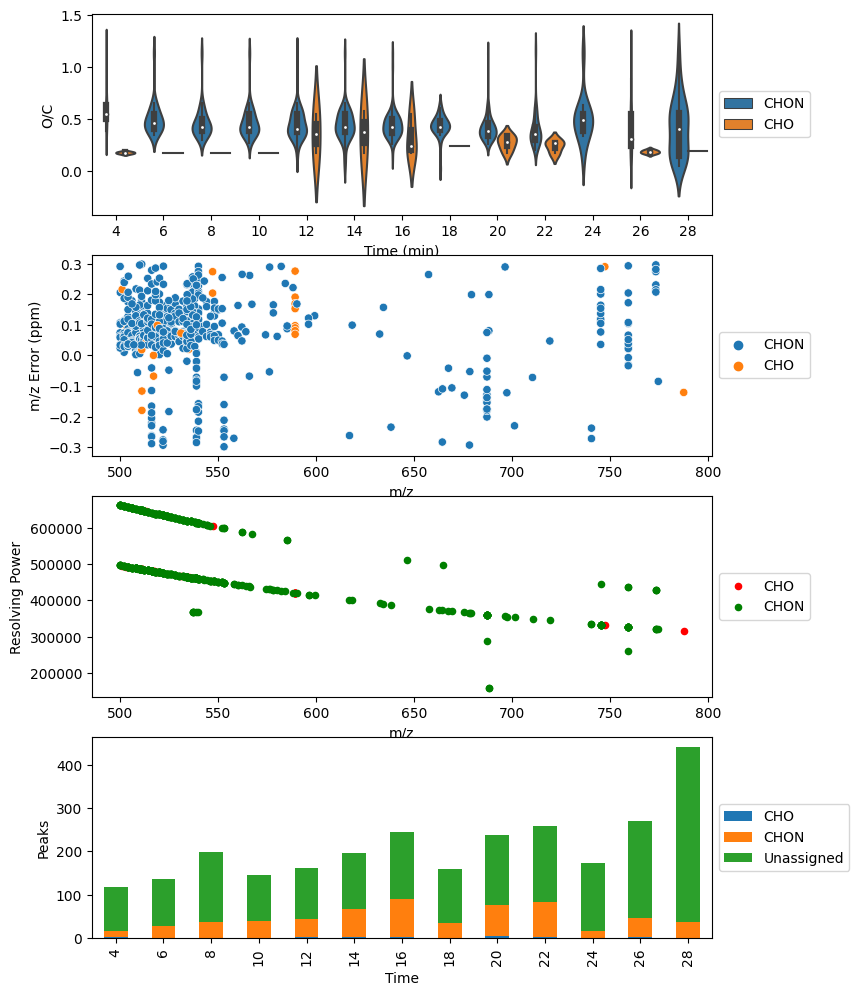

In [159]:
data3.assess_all_results()

In [180]:
data_df = data.complete_results_df

data_df = add_mzwindow_col(data_df)

data_df.to_csv("/Users/christiandewey/Library/CloudStorage/Box-Box/Boiteau Lab/Mass Spec Data/21T at NHMFL/2022-10 Nicole & Christian/Christian/spring/assignments/spring-all.csv")

In [181]:
data_df['m/z window'].unique()

array(['500-600 m/z', '700-800 m/z', '600-800 m/z', '400-600 m/z',
       '600-700 m/z'], dtype=object)

array(['20221103_LBA_Boiteau_Zorbax3p5_qh2o_700-800_221105000304.raw',
       '20221103_LBA_Boiteau_Zorbax3p5_qh2o_600-700_221104231550.raw',
       '20221103_LBA_Boiteau_Zorbax3p5_qh2o_500-600_221104222837.raw'],
      dtype=object)

In [184]:
data3_df = data3.complete_results_df


array(['700-800 m/z', '600-700 m/z', '500-600 m/z'], dtype=object)

In [185]:

data3_df_0 = add_mzwindow_col(data3_df)

data3_df.to_csv("/Users/christiandewey/Library/CloudStorage/Box-Box/Boiteau Lab/Mass Spec Data/21T at NHMFL/2022-10 Nicole & Christian/Christian/spring/assignments/spring-qh2o_partial.csv")
data3_df['m/z window'].unique()

array(['700-800 m/z', '600-700 m/z', '500-600 m/z'], dtype=object)

In [186]:
data_df = pd.concat([data_df, data2_df, data3_df])

data_df['m/z window'].unique()

array(['500-600 m/z', '700-800 m/z', '600-800 m/z', '400-600 m/z',
       '600-700 m/z', '200-1200 m/z', '400-500 m/z'], dtype=object)

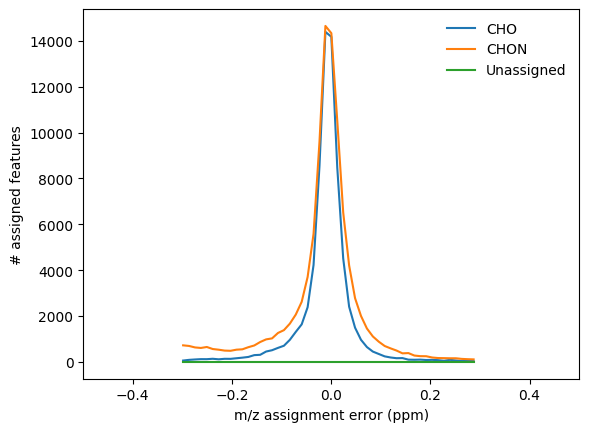

In [187]:
df_molclass = assignMolClass(data_df)

pltMZerror(df_molclass)

plt.show()


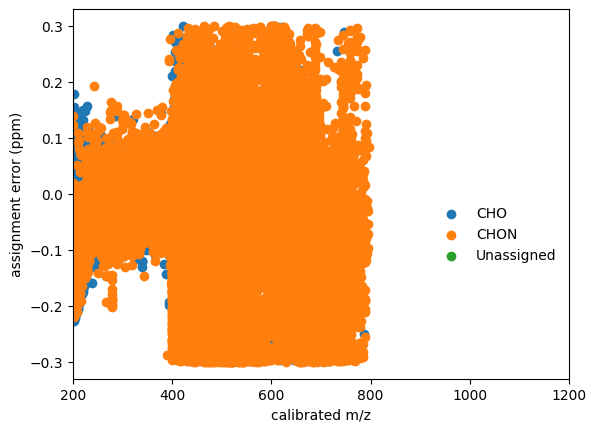

In [188]:
dfmolclass = assignMolClass(data_df)

pltMZerror_pts(dfmolclass)

plt.show()


In [189]:
files = pd.unique(data_df['file'])
print(files)

['20221103_LBA_Boiteau_Zorbax3p5_spring_500_600_221105031157.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_spring_500_600.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_qh2o_500-600.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_spring_700_800.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_spring_700_800_221105044624.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_qh2o_700-800.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_spring_600_800_221105062053.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_spring_600_800.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_spring_400_600.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_spring_400_600_221105053340.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_qh2o_600-700.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_spring_600_700_221105035911.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_spring_600_700.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz_221105013731.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500_221104214121.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_qh2o_fullmz_221105005017.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz.raw'
 '202211

In [210]:
list100mz = []
list200mz = []
listfullzmz = [] 

for mzwindow in data_df['m/z window'].unique():

    r_df = data_df[data_df['m/z window'] == mzwindow]

    if (mzwindow == '400-600 m/z') or (mzwindow == '600-800 m/z'):
        list200mz.append(r_df)

    elif (mzwindow == '400-500 m/z') or (mzwindow == '500-600 m/z') or (mzwindow == '600-700 m/z') or (mzwindow == '700-800 m/z'):
        list100mz.append(r_df) 

    elif (mzwindow == '200-1200 m/z'):
        listfullzmz.append(r_df) 



mz100 = pd.concat(list100mz)
mz200 = pd.concat(list200mz)
mzfull = pd.concat(listfullzmz)


In [211]:
print(data_df['m/z window'].unique())

['500-600 m/z' '700-800 m/z' '600-800 m/z' '400-600 m/z' '600-700 m/z'
 '200-1200 m/z' '400-500 m/z']


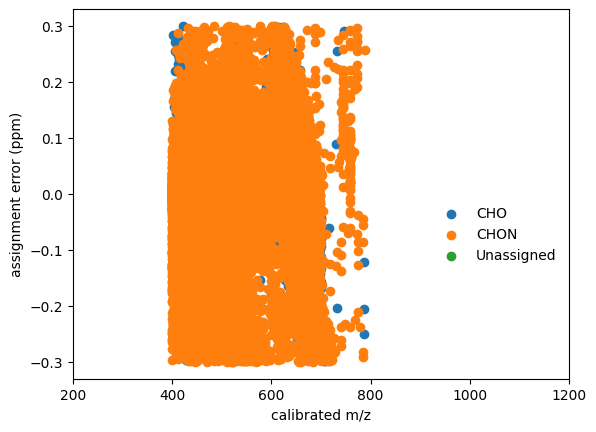

In [212]:

pltMZerror_pts(assignMolClass(mz100))

plt.show()

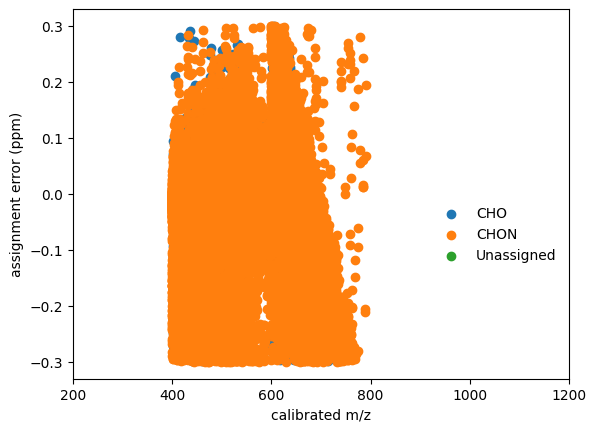

In [213]:

pltMZerror_pts(assignMolClass(mz200))

plt.show()

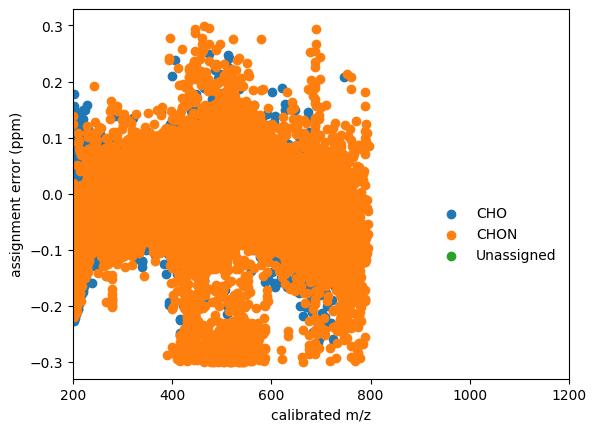

In [214]:
pltMZerror_pts(assignMolClass(mzfull))

plt.show()

In [215]:
assigned_100mz = mz100[~mz100['Molecular Formula'].isnull()]
assigned_200mz = mz200[~mz200['Molecular Formula'].isnull()]
assigned_fullmz = mzfull[~mzfull['Molecular Formula'].isnull()]

print('100 m/z windowing: \n%s features total; %s assigned (%.1f%%)' %(np.shape(assigned_100mz)[0], np.shape(mz100)[0], np.shape(assigned_100mz)[0] / np.shape(mz100)[0] * 100))
print('200 m/z windowing: \n%s features total; %s assigned (%.1f%%)' %(np.shape(assigned_200mz)[0], np.shape(mz200)[0], np.shape(assigned_200mz)[0] / np.shape(mz200)[0] * 100))
print('200-1200 m/z window: \n%s features total; %s assigned (%.1f%%)' %(np.shape(assigned_fullmz)[0], np.shape(mz100)[0], np.shape(assigned_fullmz)[0] / np.shape(mzfull)[0] * 100))


100 m/z windowing: 
60451 features total; 114560 assigned (52.8%)
200 m/z windowing: 
63591 features total; 107930 assigned (58.9%)
200-1200 m/z window: 
76987 features total; 114560 assigned (63.9%)


total # results: 60451
# unique results: 37702
['20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500_221104214121.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_qh2o_500-600_221104222837.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_qh2o_500-600.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_qh2o_600-700.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_qh2o_700-800.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_qh2o_600-700_221104231550.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_qh2o_700-800_221105000304.raw']


ValueError: Could not interpret value `mol_class` for parameter `hue`

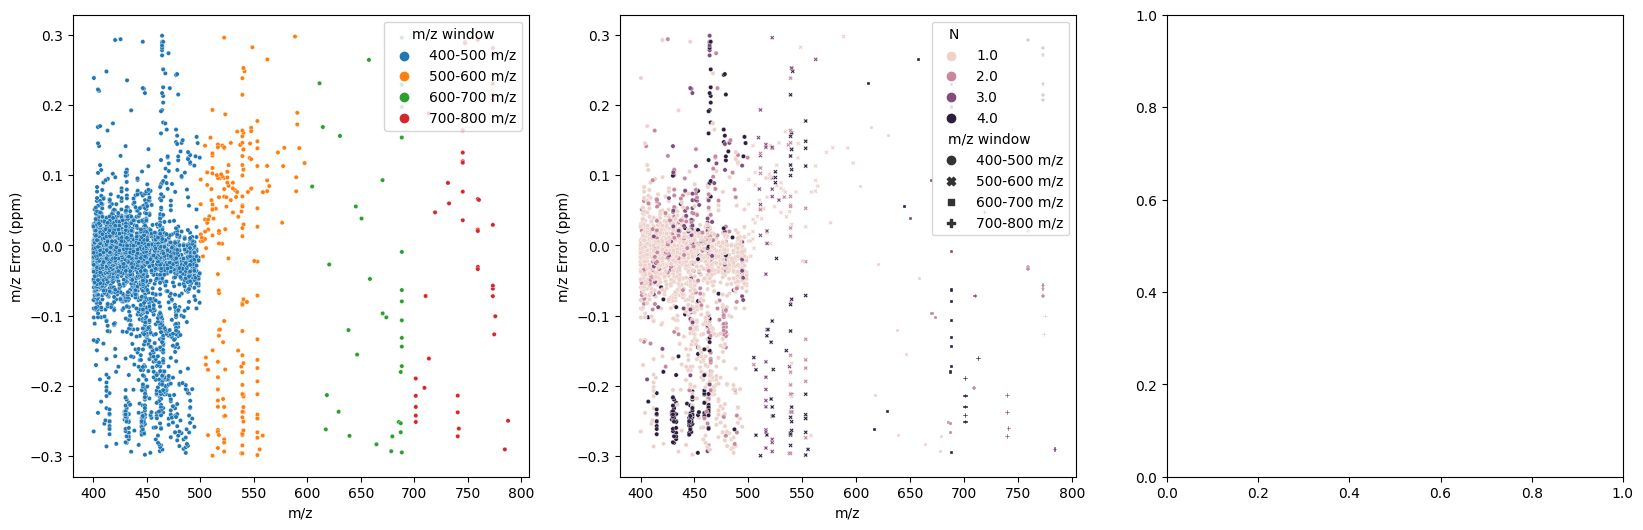

In [217]:

unique_100mz = getUniqueFeatures(assigned_100mz)
mask = unique_100mz['file'].str.contains('qh2o', case=False, na=False)
unique_100mz_b=unique_100mz[mask]

fig = plotUnique(unique_100mz_b,ps=10)
plt.tight_layout()
plt.show()
#plt.close('all')

In [197]:

def plotUnique(df,ps=50):
    print(df['file'].unique())
    fig, (ax2, ax3, ax4) = plt.subplots(1,3,figsize = (20,6))
    #sns.violinplot(x="Time", y="O/C", hue='mol_class', data=unique_results, ax=ax1)
    sns.scatterplot(x='m/z',y='m/z Error (ppm)', hue='m/z window', data=df, ax=ax2,s=ps)
    #ax1.set(xlabel='Time (min)')
    #ax2.set(xlabel='Time (min)')
    sns.scatterplot(x='m/z',y='m/z Error (ppm)',hue='N', style='m/z window',data=df,ax=ax3,s=ps)
    sns.scatterplot(x='m/z',y='Resolving Power',hue='mol_class',data=df,ax=ax4)
    
    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax4.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    #fig.savefig('unique_results.pdf', bbox_to_inches='tight')

    return fig


total # results: 52359
# unique results: 32626
['20221103_LBA_Boiteau_Zorbax3p5_spring_500_600.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_spring_400_500_221105022444.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_spring_400_500.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_spring_600_700.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_spring_500_600_221105031157.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_spring_600_700_221105035911.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_spring_700_800.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_spring_700_800_221105044624.raw']


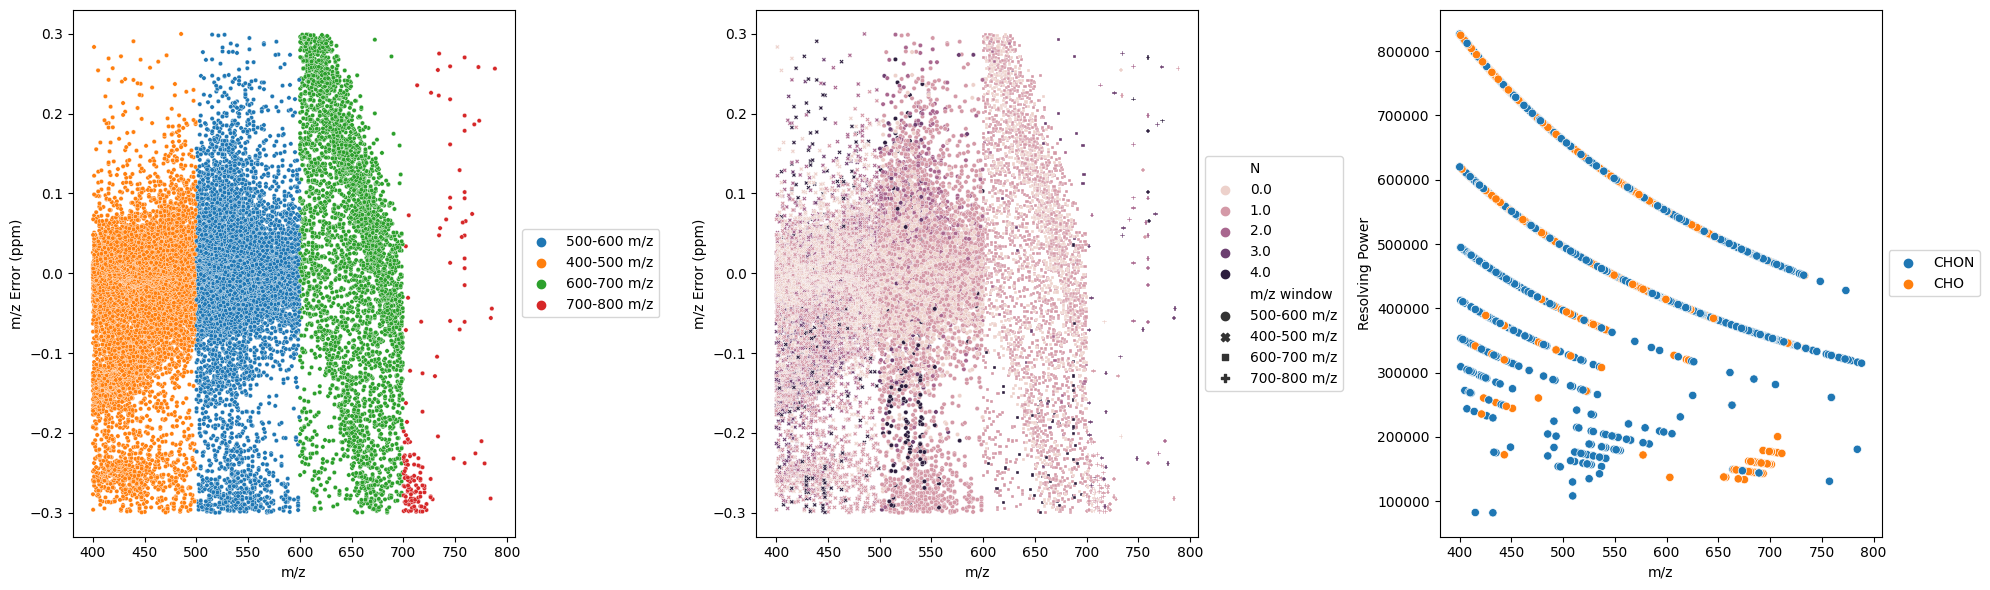

In [199]:

assigned_100mz = assignMolClass(assigned_100mz)
unique_100mz = getUniqueFeatures(assigned_100mz)

mask = ~unique_100mz['file'].str.contains('qh2o', case=False, na=False)
unique_100mz_nb=unique_100mz[mask]
fig = plotUnique(unique_100mz_nb,ps=10)
plt.tight_layout()
plt.show()
#plt.close('all')

total # results: 60451
# unique results: 37702
['20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500_221104214121.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_qh2o_500-600_221104222837.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_qh2o_500-600.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_qh2o_600-700.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_qh2o_700-800.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_qh2o_600-700_221104231550.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_qh2o_700-800_221105000304.raw']


ValueError: Could not interpret value `mol_class` for parameter `hue`

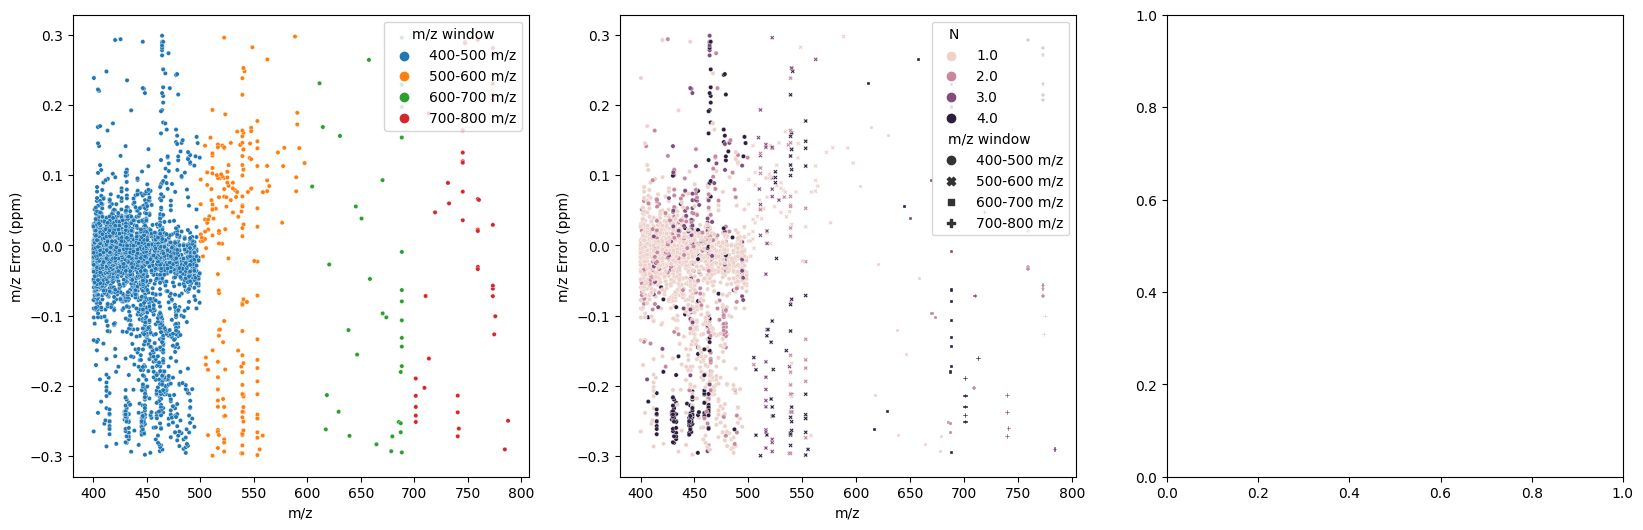

In [217]:

unique_100mz = getUniqueFeatures(assigned_100mz)
mask = unique_100mz['file'].str.contains('qh2o', case=False, na=False)
unique_100mz_b=unique_100mz[mask]

fig = plotUnique(unique_100mz_b,ps=10)
plt.tight_layout()
plt.show()
#plt.close('all')

total # results: 55219
# unique results: 29401
['20221103_LBA_Boiteau_Zorbax3p5_spring_400_600.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_spring_600_800_221105062053.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_spring_400_600_221105053340.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_spring_600_800.raw']


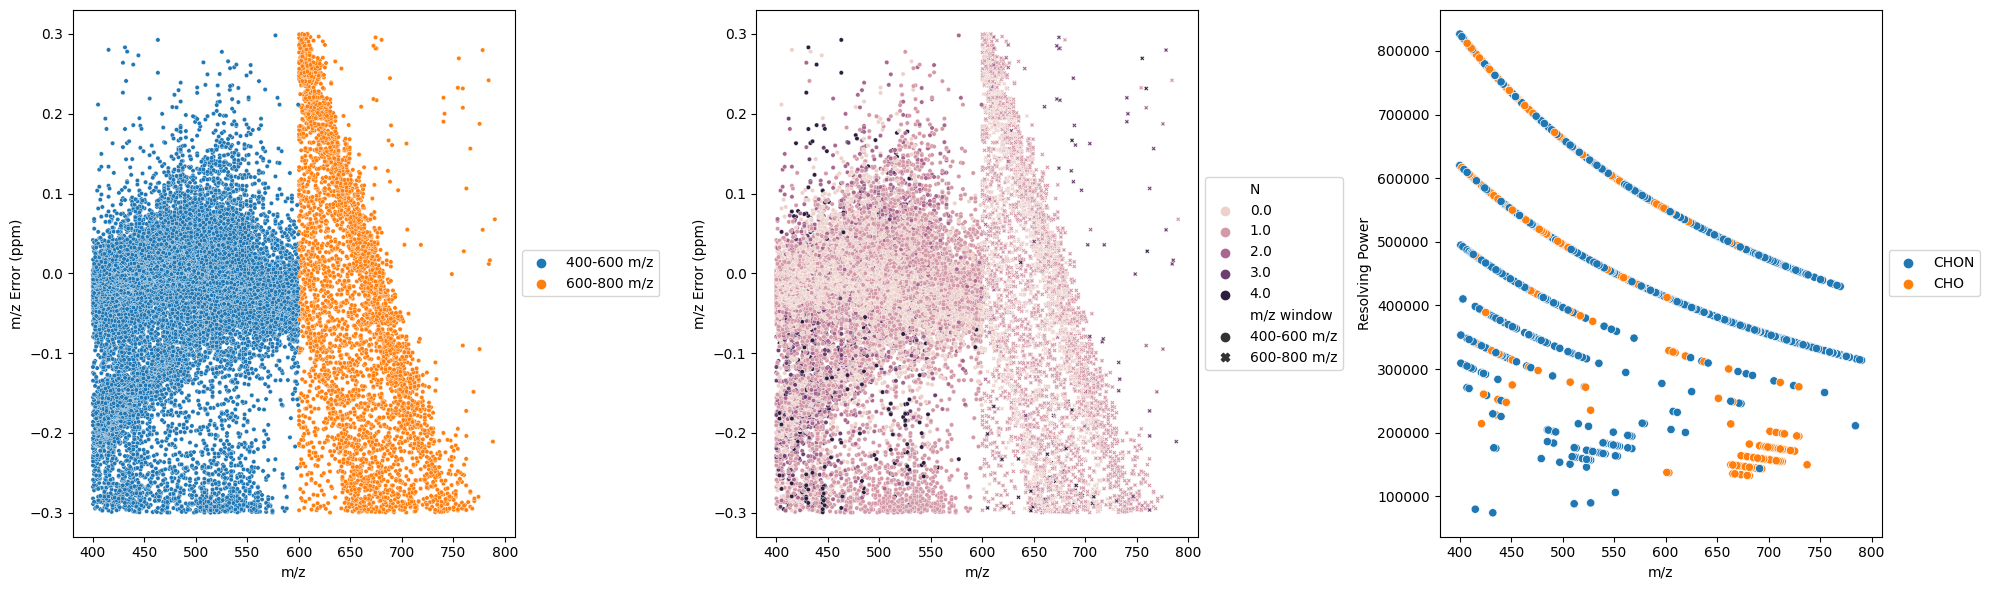

In [202]:
assigned_200mz = assignMolClass(assigned_200mz)
unique_200mz = getUniqueFeatures(assigned_200mz)

mask = ~unique_200mz['file'].str.contains('qh2o', case=False, na=False)
unique_200mz_nb=unique_200mz[mask]


fig = plotUnique(unique_200mz_nb,ps=10)
plt.tight_layout()
plt.show()
plt.close('all')

In [208]:
def addRepCol(df):

    df['Rep'] = df.index
    
    r = 0

    for file in df['file']:

        temp = file.split('_')

        if len(temp) == 7:

            df['Rep'].iloc[r] = 1

        elif len(temp) == 8:

            df['Rep'].iloc[r] = 2

    return df 



In [209]:
data_df = addRepCol(data_df)

In [ ]:


for bf in blank_files:

    div = bf.split('_')

    if len(div) == 7:

        if div[5] == 400:

            blkfile = bf
        
        elif div[5] == 500:

            blkfile = bf

        

    elif len(div) == 8:



(3805, 49)


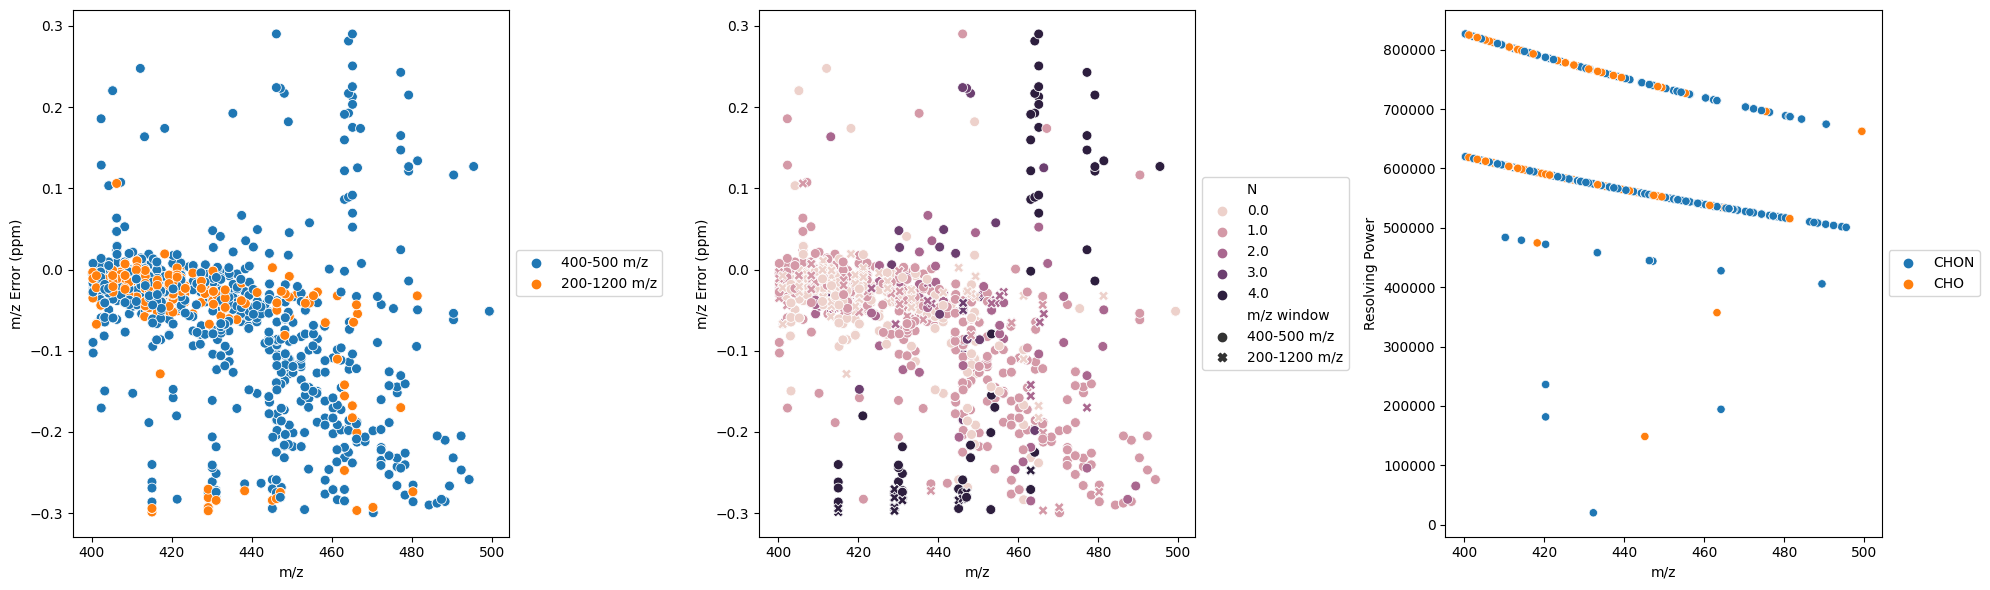

In [172]:




bsdf = blankSubtract(unique,blnkfile=bfnrw, blnkthresh=0.2)
print(np.shape(bsdf))
fig = plotUnique(bsdf)
plt.tight_layout()
plt.show()
plt.close('all')

In [174]:
bsdf400_500=bsdf[bsdf['m/z window'] == '400-500 m/z']
print(np.shape(bsdf400_500[abs(bsdf400_500['m/z Error (ppm)']) <= 0.2]))

bsdf_fullmz=bsdf[bsdf['m/z window'] == '200-1200 m/z']
print(np.shape(bsdf_fullmz[abs(bsdf_fullmz['m/z Error (ppm)']) <=0.2]))

(2183, 49)
(1172, 49)


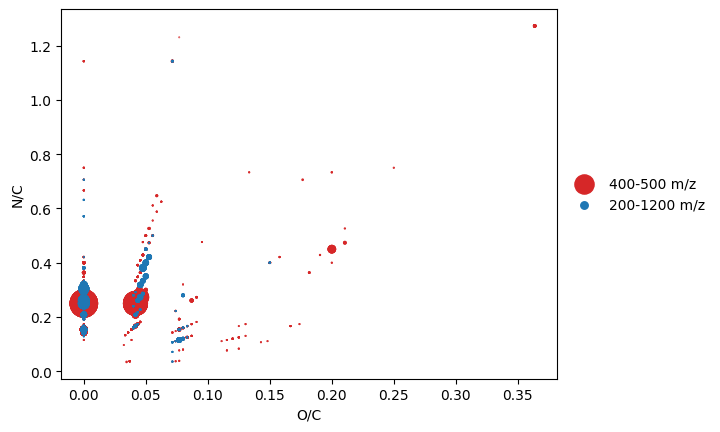

In [188]:
df = bsdf400_500[abs(bsdf400_500['m/z Error (ppm)']) <= 0.2]
df2 = bsdf_fullmz[abs(bsdf_fullmz['m/z Error (ppm)']) <= 0.2]
fig, ax = plt.subplots()
ax.scatter(x=df['N/C'],y=df['O/C'],s=df['Peak Height']/3000,c='C3',label='400-500 m/z')
ax.scatter(x=df2['N/C'],y=df2['O/C'],s=df2['Peak Height']/3000,c='C0',label='200-1200 m/z')
ax.set(xlabel='O/C',ylabel='N/C')
#ax.set_xlim(0,1.2)
#ax.set_ylim(0,0.5)
ax.legend(frameon=False, bbox_to_anchor=(1.0,0.5), loc='center left')
plt.show()

In [ ]:
df = bsdf400_500[abs(bsdf400_500['m/z Error (ppm)']) <= 0.2]
df2 = bsdf_fullmz[abs(bsdf_fullmz['m/z Error (ppm)']) <= 0.2]

In [45]:

def getParser(file):
    parser = rawFileReader.ImportMassSpectraThermoMSFileReader(file)
    return parser

def assign_formula(parser, interval, timerange, refmasslist=None):
    #Function to build formula assignment lists
    #Retrieve TIC for MS1 scans over the time range between 'timestart' and 'timestop' 

    tic=parser.get_tic(ms_type='MS')[0]
    tic_df=pd.DataFrame({'time': tic.time,'scan': tic.scans})

    times=list(range(timerange[0],timerange[1],interval))

    results=[]
    
    for timestart in times:

        scans=tic_df[tic_df.time.between(timestart,timestart+interval)].scan.tolist()

        mass_spectrum = parser.get_average_mass_spectrum_by_scanlist(scans)    
        mass_spectrum.molecular_search_settings.ion_charge = 1

        #mass_spectrum.mass_spectrum.settings.calib_sn_threshold
        #mass_spectrum.mass_spectrum.settings.calib_pol_order
        #mass_spectrum.recalibrate_mass_spectrum(mass_spectrum, imzmeas, mzrefs, order=2)
        #MzDomainCalibration(mass_spectrum, ref_file_location).run()

        if refmasslist:
            mass_spectrum.settings.min_calib_ppm_error = 10
            mass_spectrum.settings.max_calib_ppm_error = -10
            calfn = MzDomainCalibration(mass_spectrum, refmasslist)
            ref_mass_list_fmt = calfn.load_ref_mass_list(refmasslist)

            imzmeas, mzrefs = calfn.find_calibration_points(mass_spectrum, ref_mass_list_fmt,
                                                        calib_ppm_error_threshold=(0, 2.0),
                                                        calib_snr_threshold=3)

            calfn.recalibrate_mass_spectrum(mass_spectrum, imzmeas, mzrefs, order=2)


        SearchMolecularFormulas(mass_spectrum, first_hit=False).run_worker_mass_spectrum()

        mass_spectrum.percentile_assigned(report_error=True)

        assignments=mass_spectrum.to_dataframe()

        assignments['Time']=timestart

        results.append(assignments)
    
    results=pd.concat(results,ignore_index=True)

    return(results)    

def plot_ms(df1, start_mz, end_mz, tstart, df2=None,df3=None, assignment= None, ax_ms=None, lbls=None, norm=False, labs=False, colors=None):   
    if ax_ms == None:
        f, ax = plt.subplots()
    
    else:
        ax = ax_ms

    if colors is not None:
        cols = colors
    else:
        cols = ['C0', 'C1', 'C2']
    mzrange= end_mz - start_mz
    ms_t_int=df1[df1['Time'] == tstart]
    ms_df = ms_t_int[((ms_t_int['Calibrated m/z']-start_mz)<mzrange) & ((ms_t_int['Calibrated m/z']-start_mz)>0)]

    maxdf1 = max(ms_df['S/N'])

    if norm:
        ms_df['S/N Norm'] = ms_df['S/N'] / maxdf1
    else:
        ms_df['S/N Norm'] = ms_df['S/N'] 

    

    print(ms_df['S/N Norm'])

    if lbls is not None:
        labels = lbls
    else:
        lbls = [None, None, None]

 
    _, stemlines1, _ =ax.stem('Calibrated m/z','S/N Norm',data=ms_df,  markerfmt=' ', basefmt=' ', linefmt=cols[0], label = labels[0])
    
    if df2 is not None:
        ms_t_int2=df2[df2['Time'] == tstart]
        ms_df2 = ms_t_int2[(abs(ms_t_int2['Calibrated m/z']-start_mz)<mzrange)& ((ms_t_int2['Calibrated m/z']-start_mz)>0)]

        maxdf2 = max(ms_df2['S/N'])

        if norm:
            ms_df2['S/N Norm'] = ms_df2['S/N'] / maxdf2
        else:
            ms_df2['S/N Norm'] = ms_df2['S/N'] 
        
        _, stemlines2, _ =ax.stem('Calibrated m/z','S/N Norm',data=ms_df2,  markerfmt=' ', basefmt=' ', linefmt=cols[1], label = labels[1])

    if df3 is not None:
        ms_t_int3=df3[df3['Time'] == tstart]
        ms_df3 = ms_t_int3[(abs(ms_t_int3['Calibrated m/z']-start_mz)<mzrange)& ((ms_t_int3['Calibrated m/z']-start_mz)>0)]

        maxdf3 = max(ms_df3['S/N'])

        if norm:
            ms_df3['S/N Norm'] = ms_df3['S/N'] / maxdf3
        else:
            ms_df3['S/N Norm'] = ms_df3['S/N'] 
        
        _, stemlines3, _ =ax.stem('Calibrated m/z','S/N Norm',data=ms_df3,  markerfmt=' ', basefmt=' ', linefmt=cols[2], label = labels[2])
    
    if df3 is not None:
        ax.set_ylim(0, max([maxdf1, maxdf2, maxdf3]) * 1.1)
    elif df2 is not None:
        ax.set_ylim(0, max([maxdf1, maxdf2]) * 1.1)
    else: 
        ax.set_ylim(0, maxdf1 * 1.1)

    ax.set_xlim(left = start_mz - mzrange*0.1, right = start_mz + mzrange + mzrange*0.1) 

    if labs:
        for mzr,peakr,mf,er in zip(ms_df['Calibrated m/z'], ms_df['S/N Norm'], ms_df['Molecular Formula'],  ms_df['m/z Error (ppm)']):

            #if (mzr- target_mz)  == 0:
            #    mz_text = ' m/z\n%.4f' % (mzr)
            #else:
            #    mz_text = r'$\Delta$' + ' m/z\n%.4f' % (mzr- target_mz)

            mz_text = 'm/z %.4f\n%s\n%.3f ppm' % (mzr,mf,er)
            ax.text(mzr, peakr + 0.02 *max(ms_df['S/N Norm']), mz_text, ha = 'center', fontsize = 'xx-small', weight = 'bold', color=cols[0])

        if df2 is not None:

            for mzr,peakr,mf, er in zip(ms_df2['Calibrated m/z'], ms_df2['S/N Norm'], ms_df2['Molecular Formula'], ms_df2['m/z Error (ppm)']):

            #if (mzr- target_mz)  == 0:
            #    mz_text = ' m/z\n%.4f' % (mzr)
            #else:
            #    mz_text = r'$\Delta$' + ' m/z\n%.4f' % (mzr- target_mz)

                mz_text = 'm/z %.4f\n%s\n%.3f ppm' % (mzr,mf,er)
                ax.text(mzr, peakr + 0.02 *max(ms_df2['S/N Norm']), mz_text, ha = 'center', fontsize = 'xx-small', weight = 'bold', color = cols[1])

        if df3 is not None:

            for mzr,peakr,mf, er in zip(ms_df3['Calibrated m/z'], ms_df3['S/N Norm'], ms_df3['Molecular Formula'], ms_df3['m/z Error (ppm)']):

            #if (mzr- target_mz)  == 0:
            #    mz_text = ' m/z\n%.4f' % (mzr)
            #else:
            #    mz_text = r'$\Delta$' + ' m/z\n%.4f' % (mzr- target_mz)

                mz_text = 'm/z %.4f\n%s\n%.3f ppm' % (mzr,mf,er)
                ax.text(mzr, peakr + 0.02 *max(ms_df3['S/N Norm']), mz_text, ha = 'center', fontsize = 'xx-small', weight = 'bold', color = cols[2])

   # theor_mz=pattern.mdiff+result['mass']
   # theor_int=pattern.ratio*result['abundance']
   # ax.stem(theor_mz,theor_int, basefmt=' ',linefmt='gray')

   # for isotope in pattern.isotope[pattern.requirement=='Y']:
   #     ax.stem('mz','intense',data=result[isotope],  markerfmt=' ', basefmt=' ',linefmt='red')
    if ax == None:

        ax.legend(('other', 'target'),bbox_to_anchor=(1.05, 1.0), loc='upper left',frameon=False)

        if(assignment):

            mf = assignment[0]
            score = assignment[1]
            er = assignment[2]

            ax.text(1.05,0.7,mf,transform=ax.transAxes)
            ax.text(1.05,0.6,'Error (ppm) = %.3f ' %er ,transform=ax.transAxes)
            ax.text(1.05,0.5,'Score = %.3f' %score ,transform=ax.transAxes)

    if norm: 
        ax.set(xlabel='Calibrated m/z',ylabel='Normalized S/N')
    else: 
        ax.set(xlabel='Calibrated m/z',ylabel='S/N')
    #ax.set_title('%.2f' %timerange[0] + ' to %.2f' %timerange[1] +' min', fontsize = 'medium')
    ax.legend(bbox_to_anchor = (1.00, 0.5), frameon =False, loc = 'center left')
    ax.axhline(y=0.0, color='black')
    plt.setp(stemlines1,'color', cols[0], 'linewidth', 2)
    if df2 is not None:
        plt.setp(stemlines2, 'color', cols[1],'linewidth', 2)
    if df3 is not None:
        plt.setp(stemlines3, 'color', cols[2],'linewidth', 2)
    plt.tight_layout()
    if ax_ms == None:
        return ax


def filterMzRange(results, mz_range):

    mz_i = mz_range[0]
    mz_f = mz_range[1]

    sub = results[(results['m/z'] >= mz_i) & (results['m/z'] <= mz_f)]

    return sub


def pltMZerror(results, bins=50):
    ## assignment error distribution
    _, ax = plt.subplots()
    for mol_class in sorted(results['mol_class'].unique()):

        counts, bins = np.histogram(np.asarray(results[results['mol_class']==mol_class]['m/z Error (ppm)']),bins = bins)

        ax.plot(bins[:-1], counts, label = mol_class)

    ax.set_xlim(-0.5,0.5)
    ax.legend(frameon=False)
    ax.set_xlabel('m/z assignment error (ppm)')
    ax.set_ylabel('# assigned features')

    return ax

def pltMZerror_pts(results):
    ## assignment error distribution
    _, ax = plt.subplots()
    for mol_class in sorted(results['mol_class'].unique()):

        ax.scatter(results[results['mol_class']==mol_class]['Calibrated m/z'], results[results['mol_class']==mol_class]['m/z Error (ppm)'], label = mol_class)

    #ax.set_xlim(-0.5,0.5)
    ax.legend(frameon=False,bbox_to_anchor=(1.0, 0.5))
    ax.set_xlabel('calibrated m/z')
    ax.set_ylabel('assignment error (ppm)')

    return ax

def assignMolClass(resultsdf, mz_cutoff = 800, sn_lim = 3):

    filtered_results=resultsdf[(resultsdf['m/z']<mz_cutoff) & (resultsdf['S/N']>sn_lim)]

    filtered_results['N']=filtered_results['N'].fillna(0)
    filtered_results['O']=filtered_results['O'].fillna(0)
    #filtered_results['S']=filtered_results['S'].fillna(0)
    #filtered_results['P']=filtered_results['Fe'].fillna(0)
    #filtered_results['Cu']=filtered_results['Cu'].fillna(0)

    filtered_results['mol_class']='Unassigned'
    filtered_results['mol_class'][filtered_results['C']>0]='CHO'
    filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['N']>0.5)]='CHON'
    #filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['S']>0.5)]='CHOS'
    #filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['Fe']>0.5)]='CHOFe'
    #iltered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['Cu']>0.5)]='CHOCu'
    #filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['Cu']>0.5) & (filtered_results['N']>0.5)]='CHONCu'
    #filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['Cu']>0.5) & (filtered_results['S']>0.5)]='CHOSCu'
    #filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['Na']>0.5) & (filtered_results['N']>0.5)]='CHONNa'
    #filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['P']>0.5) & (filtered_results['Na']>0.5) & (filtered_results['N']>0.5)]='CHONPNa'


    results= filtered_results #[filtered_results['mol_class'] != 'Unassigned'] #[filtered_results['Is Isotopologue']==0]
    results['N/C']=results['O']/results['C']
    results['H/C']=results['H']/results['C']
    results['N/C']=results['N']/results['C']

    return results


In [ ]:
# 1: assign formula to full scan 
MSParameters.mass_spectrum.threshold_method = 'signal_noise'
MSParameters.mass_spectrum.s2n_threshold = 2
MSParameters.ms_peak.peak_min_prominence_percent = 0.001

MSParameters.molecular_search.error_method = 'None'
MSParameters.molecular_search.min_ppm_error = -0.3
MSParameters.molecular_search.max_ppm_error = 0.3

MSParameters.molecular_search.isProtonated = True
MSParameters.molecular_search.isRadical = False
MSParameters.molecular_search.isAdduct = False

MSParameters.molecular_search.score_method = "prob_score"
MSParameters.molecular_search.output_score_method = "prob_score"


MSParameters.molecular_search.url_database = None
MSParameters.molecular_search.min_dbe = -1
MSParameters.molecular_search.max_dbe = 20

MSParameters.molecular_search.usedAtoms['C'] = (1,50)
MSParameters.molecular_search.usedAtoms['H'] = (4,100)
MSParameters.molecular_search.usedAtoms['O'] = (1,20)
MSParameters.molecular_search.usedAtoms['N'] = (0,6)
MSParameters.molecular_search.usedAtoms['Cu'] = (0,1)
MSParameters.molecular_search.usedAtoms['S'] = (0,1)


In [ ]:

data2='/Users/christiandewey/Library/CloudStorage/Box-Box/Boiteau Lab/Mass Spec Data/21T at NHMFL/2022-10 Nicole & Christian/Christian/spring/20221103_LBA_Boiteau_Zorbax3p5_spring_400_500.raw'
data1='/Users/christiandewey/Library/CloudStorage/Box-Box/Boiteau Lab/Mass Spec Data/21T at NHMFL/2022-10 Nicole & Christian/Christian/spring/20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz.raw'
qh2o='/Users/christiandewey/Library/CloudStorage/Box-Box/Boiteau Lab/Mass Spec Data/21T at NHMFL/2022-10 Nicole & Christian/Christian/spring/20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500.raw'


refmasslist = '/Users/christiandewey/CoreMS/tests/tests_data/ftms/nom_pos.ref'

savedir = '/Users/christiandewey/Desktop/221107-CoreMS'

trange = [4,28]
interval = 2
parser1 = getParser(data1)  #fullmz
results1 = assign_formula(parser1,interval=interval,timerange=trange, refmasslist=refmasslist)



In [ ]:
#trange = [12,14]
#interval = 2
parser2 = getParser(data2)  #400-500mz
results2 = assign_formula(parser2,interval=interval,timerange=trange, refmasslist=refmasslist)



In [ ]:
fresults2 = assignMolClass(results2)

pltMZerror(fresults2, bins=75)

plt.show()

In [ ]:
pltMZerror_pts(fresults2)

plt.show()

In [ ]:
#trange = [12,14]
#interval = 4

qh2o_parser = getParser(qh2o)
qh2o_results = assign_formula(qh2o_parser,interval=interval,timerange=trange, refmasslist=refmasslist )

In [ ]:
fresults3 = assignMolClass(qh2o_results)

pltMZerror(fresults3, bins=75)

plt.show()

In [ ]:

## filter molform 
sub = filterMzRange(results1,[400,500])

blank_subtracted_n = results2[~results2['Molecular Formula'].isin(qh2o_results['Molecular Formula'])]

blank_subtracted_full = sub[~sub['Molecular Formula'].isin(qh2o_results['Molecular Formula'])]

overlap = blank_subtracted_n[blank_subtracted_n['Molecular Formula'].isin(blank_subtracted_full['Molecular Formula'])]

narrow_unique = blank_subtracted_n[~blank_subtracted_n['Molecular Formula'].isin(blank_subtracted_full['Molecular Formula'])]

full_range_bs = results1[~results1['Molecular Formula'].isin(qh2o_results['Molecular Formula'])]


In [ ]:


sn_lim = 20
df2=narrow_unique[narrow_unique['S/N']<sn_lim]

df1=blank_subtracted_full[blank_subtracted_full['S/N']<sn_lim]
df2=narrow_unique[narrow_unique['S/N']<sn_lim]
df3=overlap[overlap['S/N']<sn_lim]


df2a = sub[sub['Molecular Formula'].notna()]
df2b = sub[sub['Molecular Formula'].isna()]

n_mzs = np.shape(sub)[0]

per_a = np.shape(df2a)[0]  / (np.shape(df2a)[0] + np.shape(df2b)[0]) *100
per_b = np.shape(df2b)[0]  / (np.shape(df2a)[0] + np.shape(df2b)[0]) *100

plot_ms(df2a,df2=df2b, start_mz=400,end_mz = 500, tstart = 16, lbls=['Assigned', 'Unassigned'],labs=False) 

plt.title('200-1200 m/z window, %s peaks, %.2f%% assigned' %(n_mzs, per_a))
plt.show()






In [ ]:


df2a = results2[results2['Molecular Formula'].notna()]
df2b = results2[results2['Molecular Formula'].isna()]

n_mzs = np.shape(results2)[0]

per_a = np.shape(df2a)[0]  / (np.shape(df2a)[0] + np.shape(df2b)[0]) *100
per_b = np.shape(df2b)[0]  / (np.shape(df2a)[0] + np.shape(df2b)[0]) *100

plot_ms(df2a,df2=df2b, start_mz=400,end_mz = 500, tstart = 16, lbls=['Assigned', 'Unassigned' ],labs=False) 

plt.title('400-500 m/z window, %s peaks, %.2f%% assigned' %(n_mzs, per_a))
plt.show()

In [ ]:

df2a = results2 #[results2['Molecular Formula'].notna()]
df2b = sub #[sub['Molecular Formula'].notna()]

n_mzs = np.shape(results2)[0]

per_a = np.shape(df2a)[0]  / (np.shape(df2a)[0] + np.shape(df2b)[0]) *100
per_b = np.shape(df2b)[0]  / (np.shape(df2a)[0] + np.shape(df2b)[0]) *100

plot_ms(df2a,df2=df2b, start_mz=400,end_mz = 500, tstart = 16, lbls=['400-500 m/z', '150-2000 m/z' ],labs=False, colors=['C3','C7']) 

plt.title('Comparison of S/N')
plt.show()

In [ ]:
blank_subtracted_n = results2[~results2['Molecular Formula'].isin(qh2o_results['Molecular Formula'])]

blank_subtracted_full = sub[~sub['Molecular Formula'].isin(qh2o_results['Molecular Formula'])]

overlap = blank_subtracted_n[blank_subtracted_n['Molecular Formula'].isin(blank_subtracted_full['Molecular Formula'])]

narrow_unique = blank_subtracted_n[~blank_subtracted_n['Molecular Formula'].isin(blank_subtracted_full['Molecular Formula'])]

full_range_bs = results1[~results1['Molecular Formula'].isin(qh2o_results['Molecular Formula'])]



df2a = overlap #[results2['Molecular Formula'].notna()]
df2b = narrow_unique #[sub['Molecular Formula'].notna()]

n_mzs = np.shape(results2)[0]

per_a = np.shape(df2a)[0]  / (np.shape(df2a)[0] + np.shape(df2b)[0]) *100
per_b = np.shape(df2b)[0]  / (np.shape(df2a)[0] + np.shape(df2b)[0]) *100

plot_ms(df2a,df2=df2b, start_mz=400,end_mz = 500, tstart = 16, lbls=['Both windows', 'Only 400-500 m/z' ],labs=False,colors=['C7','C3']) 

plt.title('Assigned features')
plt.show()

In [ ]:
blank_subtracted_n = results2[~results2['Molecular Formula'].isin(qh2o_results['Molecular Formula'])]

blank_subtracted_full = sub[~sub['Molecular Formula'].isin(qh2o_results['Molecular Formula'])]

overlap = blank_subtracted_n[blank_subtracted_n['Molecular Formula'].isin(blank_subtracted_full['Molecular Formula'])]

narrow_unique = blank_subtracted_n[~blank_subtracted_n['Molecular Formula'].isin(blank_subtracted_full['Molecular Formula'])]

full_range_bs = results1[~results1['Molecular Formula'].isin(qh2o_results['Molecular Formula'])]



df2a = overlap#[overlap['S'] > 0]
df2b = narrow_unique#[narrow_unique['S'] > 0] #[sub['Molecular Formula'].notna()]



plot_ms(df2a,df2=df2b, start_mz=451,end_mz = 451.5, tstart = 16, lbls=['Both windows', 'Only 400-500 m/z' ],labs=False,colors=['C7','C3']) 

plt.title('Assigned features')
plt.show()

In [ ]:
blank_subtracted_n = results2[~results2['Molecular Formula'].isin(qh2o_results['Molecular Formula'])]

blank_subtracted_full = sub[~sub['Molecular Formula'].isin(qh2o_results['Molecular Formula'])]

overlap = blank_subtracted_n[blank_subtracted_n['Molecular Formula'].isin(blank_subtracted_full['Molecular Formula'])]

narrow_unique = blank_subtracted_n[~blank_subtracted_n['Molecular Formula'].isin(blank_subtracted_full['Molecular Formula'])]

full_range_bs = results1[~results1['Molecular Formula'].isin(qh2o_results['Molecular Formula'])]



df2a = overlap[overlap['Cu'] > 0]
df2b = narrow_unique[narrow_unique['Cu'] > 0] #[sub['Molecular Formula'].notna()]
df2c = df2b[df2b['13C'] > 0]



plot_ms(df2a,df2=df2b,df3=df2c, start_mz=400,end_mz = 500, tstart = 16, lbls=['Both windows', '400-500 m/z mono', '400-500 m/z 13C' ],labs=False) 

plt.title('Assigned features containing Cu')
plt.show()

In [ ]:
df2a_f = assignMolClass(df2a)

fig, ax = plt.subplots()
ax.scatter(x=df2a_f['N/C'],y=df2a_f['O/C'],s=df2a['Peak Height']/100,c='C3',label='400-500 m/z')
ax.set(xlabel='O/C',ylabel='N/C')
ax.set_xlim(0,1.2)
ax.set_ylim(0,0.5)
#ax.legend(frameon=False)
plt.show()

In [ ]:


plot_ms(df2c, start_mz=400,end_mz = 500, tstart = 16, lbls=[ '400-500 m/z 13C' ],labs=True) 

plt.title('Assigned  features detected in 400-500 m/z')
plt.show()

In [ ]:
blank_subtracted_n = results2[~results2['Molecular Formula'].isin(qh2o_results['Molecular Formula'])]

blank_subtracted_full = sub[~sub['Molecular Formula'].isin(qh2o_results['Molecular Formula'])]

overlap = blank_subtracted_n[blank_subtracted_n['Molecular Formula'].isin(blank_subtracted_full['Molecular Formula'])]

narrow_unique = blank_subtracted_n[~blank_subtracted_n['Molecular Formula'].isin(blank_subtracted_full['Molecular Formula'])]

full_range_bs = results1[~results1['Molecular Formula'].isin(qh2o_results['Molecular Formula'])]



df2b = narrow_unique[narrow_unique['Cu'] > 0] #[sub['Molecular Formula'].notna()]
df2a = overlap[overlap['Cu'] > 0] #[sub['Molecular Formula'].notna()]


plot_ms(df2b, start_mz=400,end_mz = 500, tstart = 16, lbls=[ '' ],labs=True,colors=['C1']) 

plot_ms(df2a, start_mz=400,end_mz = 500, tstart = 16, lbls=[ '' ],labs=True,colors=['C0']) 


plt.title('Assigned Cu features detected in 400-500 m/z')
plt.show()

In [ ]:
blank_subtracted_n = results2[~results2['Molecular Formula'].isin(qh2o_results['Molecular Formula'])]

blank_subtracted_full = sub[~sub['Molecular Formula'].isin(qh2o_results['Molecular Formula'])]

overlap = blank_subtracted_n[blank_subtracted_n['Molecular Formula'].isin(blank_subtracted_full['Molecular Formula'])]

narrow_unique = blank_subtracted_n[~blank_subtracted_n['Molecular Formula'].isin(blank_subtracted_full['Molecular Formula'])]

full_range_bs = results1[~results1['Molecular Formula'].isin(qh2o_results['Molecular Formula'])]



df2a = narrow_unique[narrow_unique['Cu'] > 0] #[sub['Molecular Formula'].notna()]

df2b = blank_subtracted_n.loc[blank_subtracted_n['Index'].isin(df2a['Mono Isotopic Index'] )]
print(np.shape(df2b))

plot_ms(df2a, df2=df2b,start_mz=422,end_mz = 424, tstart = 16, lbls=[ '13C isotopologue', 'Monoisotopic' ],labs=True) 

plt.title('Assigned 13C features detected in 400-500 m/z')
plt.show()

In [ ]:
## van Krevelen plots 
## N/C, H/C
sub = filterMzRange(fresults1,[400,500])
fig, ax = plt.subplots()
ax.scatter(x=fresults2['N/C'],y=fresults2['N/C'],s=fresults2['Peak Height']/4000,c='C3',label='400-500 m/z')
ax.scatter(x=sub['N/C'],y=sub['N/C'],s=sub['Peak Height']/4000,c='C7',label='Both windows')
ax.set(xlabel='N/C',ylabel='N/C')
ax.legend(frameon=False)
plt.show()

In [ ]:

## O/C, N/C

sub = filterMzRange(fresults1,[400,500])
fig, ax = plt.subplots()
ax.scatter(x=fresults2['O/C'],y=fresults2['N/C'],s=fresults2['Peak Height']/4000,c='C3',label='400-500 m/z')
ax.scatter(x=sub['O/C'],y=sub['N/C'],s=sub['Peak Height']/4000,c='C7',label='Both windows')
ax.set(xlabel='O/C',ylabel='N/C')
ax.legend(frameon=False)
plt.show()

In [ ]:
## van Krevelen plots 
## O/C, N/C
sub = filterMzRange(fresults1,[400,500])
fig, ax = plt.subplots()
ax.scatter(x=fresults2['O/C'],y=fresults2['N/C'],s=fresults2['Peak Height']/4000,c='C3',label='400-500 m/z')
ax.scatter(x=sub['O/C'],y=sub['N/C'],s=sub['Peak Height']/4000,c='C7',label='Both windows')
ax.set(xlabel='O/C',ylabel='N/C')
ax.legend(frameon=False)
plt.show()